<a href="https://colab.research.google.com/github/webbigdata-jp/python_sample/blob/main/FanFic_Illustrator_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [FanFic-Illustrator](https://huggingface.co/webbigdata/FanFic-Illustrator) Demo.

Enter your original story or fan fiction and we'll create illustrations for it.  
オリジナル小説や二次創作したファン小説を入力すると、その文章用の挿絵を作成します  


## How to run/動かし方

If you are on a github page, click the Open in Colab button at the top of the screen to launch Colab.

あなたが見ているのがgithubのページである場合、画面上部に表示されているOpen in Colabボタンを押してColabを起動してください

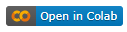

Next, run each cell one by one (i.e. click the "▷" in order as shown in the image below).  
次に、セルを１つずつ実行(つまり、以下の画像のような「▷」を順番にクリック)してください  

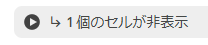


## 1. Install Required Libraries

In [1]:
%%capture
%%shell
#@title Install Required Libraries

pip install diffusers==0.32.2 transformers==4.49.0

## 2. Setting Up

2つのモデルをダウンロードするためやや時間がかかります  
This will take some time as two models will be downloaded.  

In [2]:
#@title (1)Dependent Libraries and Utility Functions/依存ライブラリとユーティリティ関数
# ======== セル1: 依存ライブラリとユーティリティ関数 ========
import gc
import os
import random
import numpy as np
import json
import torch
import uuid
from PIL import Image, PngImagePlugin
from datetime import datetime
from typing import Callable, Dict, Optional, Tuple, Any, List
import logging
import time
from pathlib import Path

# Diffusersのインポート
from diffusers import (
    EulerAncestralDiscreteScheduler,
    AutoencoderKL,
    StableDiffusionXLPipeline,
)

# ロギング設定
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

# 定数
MAX_SEED = np.iinfo(np.int32).max
OUTPUT_DIR = "./outputs"
MODEL = "cagliostrolab/animagine-xl-4.0"
MIN_IMAGE_SIZE = 512
MAX_IMAGE_SIZE = 2048
DEFAULT_NEGATIVE_PROMPT = "lowres, bad anatomy, bad hands, text, error, missing finger, extra digits, fewer digits, cropped, worst quality, low quality, low score, bad score, average score, signature, watermark, username, blurry"
DEFAULT_ASPECT_RATIO = "832 x 1216"
DEFAULT_SERIES = "original"
DEFAULT_CHARACTER = "original character"
DEFAULT_CATEGORY = "general"

# ランダムシード設定
def seed_everything(seed: int) -> torch.Generator:
    """乱数シードを設定する関数"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    generator = torch.Generator()
    generator.manual_seed(seed)
    return generator

# アスペクト比処理
def parse_aspect_ratio(aspect_ratio: str) -> Optional[Tuple[int, int]]:
    """アスペクト比を解析する関数"""
    if aspect_ratio == "Custom":
        return None
    width, height = aspect_ratio.split(" x ")
    return int(width), int(height)

def aspect_ratio_handler(
    aspect_ratio: str, custom_width: int, custom_height: int
) -> Tuple[int, int]:
    """アスペクト比に合わせて解像度を処理する関数"""
    if aspect_ratio == "Custom":
        return custom_width, custom_height
    else:
        width, height = parse_aspect_ratio(aspect_ratio)
        return width, height

# スケジューラ取得
def get_scheduler(scheduler_config: Dict, name: str) -> Optional[Callable]:
    """スケジューラを取得する関数"""
    scheduler_factory_map = {
        "Euler a": lambda: EulerAncestralDiscreteScheduler.from_config(
            scheduler_config
        ),
    }
    return scheduler_factory_map.get(name, lambda: None)()

# メモリ解放
def free_memory() -> None:
    """GPU及びシステムメモリを解放する関数"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    gc.collect()

# プロンプト前処理
def preprocess_prompt(
    style_dict,
    style_name: str,
    positive: str,
    negative: str = "",
    add_style: bool = True,
) -> Tuple[str, str]:
    """スタイルを適用してプロンプトを前処理する関数"""
    p, n = style_dict.get(style_name, style_dict["(None)"])

    if add_style and positive.strip():
        formatted_positive = p.format(prompt=positive)
    else:
        formatted_positive = positive

    combined_negative = n
    if negative.strip():
        if combined_negative:
            combined_negative += ", " + negative
        else:
            combined_negative = negative

    return formatted_positive, combined_negative

# 画像保存
def save_image(image, metadata, output_dir):
    """生成された画像を保存する関数"""
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"image_{current_time}.png"
    os.makedirs(output_dir, exist_ok=True)
    filepath = os.path.join(output_dir, filename)
    metadata_str = json.dumps(metadata)
    info = PngImagePlugin.PngInfo()
    info.add_text("parameters", metadata_str)
    image.save(filepath, "PNG", pnginfo=info)
    return filepath

# パイプラインロード
def load_pipeline(model_name: str, device: torch.device, vae: Optional[AutoencoderKL] = None) -> Any:
    """Stable Diffusionパイプラインをロードする関数"""
    try:
        logger.info(f"Loading pipeline from {model_name}...")

        # モデルIDからロード
        pipe = StableDiffusionXLPipeline.from_pretrained(
            model_name,
            vae=vae,
            torch_dtype=torch.float16,
            use_safetensors=True,
            custom_pipeline="lpw_stable_diffusion_xl",
            add_watermarker=False
        )

        pipe.to(device)
        logger.info("Pipeline loaded successfully!")
        return pipe

    except Exception as e:
        logger.error(f"Failed to load pipeline: {str(e)}", exc_info=True)
        raise

# 画像の解像度を前処理
def preprocess_image_dimensions(width, height):
    """画像の解像度を前処理する関数"""
    # 最小サイズと最大サイズの範囲内に収める
    width = max(MIN_IMAGE_SIZE, min(MAX_IMAGE_SIZE, width))
    height = max(MIN_IMAGE_SIZE, min(MAX_IMAGE_SIZE, height))

    # 8の倍数に調整（Stable Diffusionの要件）
    width = width - (width % 8)
    height = height - (height % 8)

    return width, height

# スタイル定義
styles = [
    {"name": "(None)", "prompt": "{prompt}", "negative_prompt": ""},
    {"name": "Anim4gine", "prompt": "{prompt}, depth of field, faux traditional media, painterly, impressionism, photo background", "negative_prompt": ""},
    {"name": "Painting", "prompt": "{prompt}, painterly, painting (medium)", "negative_prompt": ""},
    {"name": "Pixel art", "prompt": "{prompt}, pixel art", "negative_prompt": ""},
    {"name": "1980s", "prompt": "{prompt}, 1980s (style), retro artstyle", "negative_prompt": ""},
    {"name": "1990s", "prompt": "{prompt}, 1990s (style), retro artstyle", "negative_prompt": ""},
    {"name": "2000s", "prompt": "{prompt}, 2000s (style), retro artstyle", "negative_prompt": ""},
    {"name": "Toon", "prompt": "{prompt}, toon (style)", "negative_prompt": ""},
    {"name": "Lineart", "prompt": "{prompt}, lineart, thick lineart", "negative_prompt": ""},
    {"name": "Art Nouveau", "prompt": "{prompt}, art nouveau", "negative_prompt": ""},
    {"name": "Western Comics", "prompt": "{prompt}, western comics (style)", "negative_prompt": ""},
    {"name": "3D", "prompt": "{prompt}, 3d", "negative_prompt": ""},
    {"name": "Realistic", "prompt": "{prompt}, realistic, photorealistic", "negative_prompt": ""},
    {"name": "Neonpunk", "prompt": "{prompt}, neonpunk", "negative_prompt": ""}
]

def get_style_dict():
    """スタイル辞書を生成する関数"""
    return {style["name"]: (style["prompt"], style.get("negative_prompt", "")) for style in styles}



series_and_charcters = {
    "touhou": {
        "description": "弾幕シューティングゲームを中心とした作品群。幻想郷を舞台に、少女たちが弾幕を繰り広げる。個性的なキャラクターと、美しい音楽が魅力。同人作品として、絶大な人気を誇る。",
        "characters": {
            "hakurei reimu": {
                "gender": "female",
                "description": "博麗神社の巫女(miko)。赤いリボンと巫女服が特徴。着物は着ていない。空を飛ぶ程度の能力を持つ。面倒くさがり屋だが、幻想郷の異変を解決する。「夢想封印」などの技を使う。"
            },
            "kirisame marisa": {
                "gender": "female",
                "description": "魔法使いの少女。金髪と魔法使いの帽子が特徴。魔法を使う程度の能力を持つ。好奇心旺盛で、何にでも首を突っ込む。「マスタースパーク」などの技を使う。"
            },
            "izayoi sakuya": {
                "gender": "female",
                "description": "紅魔館のメイド長。銀髪とメイド服が特徴。時間を操る程度の能力を持つ。完璧なメイドとして、レミリアに仕える。ナイフ投げが得意。"
            },
            "remilia scarlet": {
                "gender": "female",
                "description": "紅魔館の主。吸血鬼の少女。幼い外見だが、500年以上生きている。運命を操る程度の能力を持つ。カリスマ性があり、多くの妖怪を従える。"
            },
            "flandre scarlet": {
                "gender": "female",
                "description": "レミリアの妹。吸血鬼の少女。495年間、紅魔館の地下室に閉じ込められていた。ありとあらゆるものを破壊する程度の能力を持つ。無邪気だが、破壊衝動を抑えられない。"
            }
        }
    },
    "touken ranbu": {
        "description": "名だたる刀剣が戦士の姿となった「刀剣男士」を収集・育成するシミュレーションゲーム。歴史上の合戦場を舞台に、時間遡行軍と戦う。美麗なイラストと、豪華声優陣が魅力。女性を中心に人気を集めている。",
        "characters": {
            "kashuu kiyomitsu": {
                "gender": "male",
                "description": "加州清光は、新選組 沖田総司の愛刀として知られる打刀。赤いマフラーと、黒いコートが特徴。「可愛く」いることを大切にしており、爪紅を塗っている。戦闘では、素早い動きで敵を翻弄する。"
            },
            "mikazuki munechika": {
                "gender": "male",
                "description": "三日月宗近は、天下五剣の一つで、最も美しいとされる太刀。平安時代の装束を身に纏い、優雅な雰囲気を漂わせる。「じじい」口調で話し、マイペースな性格。戦闘では、華麗な太刀筋で敵を圧倒する。"
            },
            "tsurumaru kuninaga": {
                "gender": "male",
                "description": "鶴丸国永は、平安時代の刀工・五条国永作の太刀。白い装束と、鶴を思わせる意匠が特徴。驚きを求める性格で、いたずら好き。戦闘では、軽快な動きと、トリッキーな技を繰り出す。"
            },
            "yamato-no-kami yasusada": {
                "gender": "male",
                "description": "沖田総司の刀の化身。黒髪を高くまとめ、青い目をしており、左目の下にほくろがある。白のマフラー、新撰組の羽織、黒の「花嫁の籠手」タイプの手袋、紺色の袴、黒の足袋、青の鼻緒の草履が標準の服装。普段は気楽な性格だが、戦闘になると冷酷でサディスティック"
            },
            "namazuo toushirou":{
                "gender": "male",
                "description": "薙刀から改造された脇差。外向的で明るく、ややぼんやりした性格。長い黒髪をポニーテールに結び、目立つアホ毛と紫色の目をしている。普段の服装は、軍服で、黒のネクタイと片方の肩に黒の袖がある。"
            }
        }
    },
    "vocaloid": {
        "description": "ヤマハが開発した音声合成技術、およびそのキャラクター。ユーザーが作成した楽曲を、キャラクターが歌う。初音ミクを筆頭に、様々なキャラクターが存在する。音楽シーンに大きな影響を与えている。",
        "characters": {
            "hatsune miku": {
                "gender": "female",
                "description": "ツインテールのバーチャル・シンガー。水色がイメージカラー。様々なジャンルの楽曲を歌いこなす。世界中で人気のキャラクター。ライブコンサートも開催されている。"
            },
            "kagamine rin": {
                "gender": "female",
                "description": "ショートヘアのバーチャル・シンガー。黄色がイメージカラー。鏡音レンとデュエット曲を歌うことが多い。元気で明るい歌声が特徴。ツンデレな性格とされる。"
            },
            "kagamine len": {
                "gender": "male",
                "description": "ショートヘアのバーチャル・シンガー。黄色がイメージカラー。鏡音リンとデュエット曲を歌うことが多い。力強い歌声が特徴。クールな性格とされる。"
            },
            "megurine luka": {
                "gender": "female",
                "description": "ロングヘアのバーチャル・シンガー。ピンク色がイメージカラー。日本語と英語のバイリンガル。大人っぽい歌声が特徴。クールビューティーな性格とされる。"
            },
        }
    },
    "kantai collection":{
        "description": "各キャラクターは、第二次世界大戦の海軍の軍艦を擬人化した萌えキャラクターで「艦娘」と呼ばれるかわいい女の子として描かれています。各女の子の身体的特徴、外見、性格は、実際の船と何らかの形で相関しています。",
        "characters": {
            "kaga (kancolle)": {
                "gender": "female",
                "description": "日本の航空母艦加賀の擬人化。ストイックな性格。サイドポニーテールの長い茶色の髪、つり目のような茶色の目、大きな胸。白い着物トップスと青いプリーツスカートの上に黒い胸当て、黒いサイハイソックス、厚底靴。伝統的な弓、矢筒"
            },
            "shimakaze (kancolle)": {
                "gender": "female",
                "description": "長いブロンドの髪と灰色の目。クロップ丈のセーラー服、ストライプのニーソックス、白いエルボーグローブ、お尻が見える黒いハイレグパンツの短いミニスカート、そして長く垂れ下がった「耳」の付いた黒いヘアバンドを着用",
            },
            "hibiki (kancolle)": {
                "gender": "female",
                "description": "暁型は白と濃紺のセーラー服、黒いレッグウェアも着用しています。響自身は白、水色、水色、または灰色の長い髪、青または灰色の目を持ち、黒いニーソックスとフラットキャップを着用しています。"
            },
            "shigure (kancolle)": {
                "gender": "female",
                "description": "艦隊これくしょんアニメ第2期の主人公。中くらいの長さのダークブラウン/黒髪で、肩に編んだアホ毛と青い目をしている。デフォルトの服装は白露型の制服で、黒いセーラー服、黒いソックス、茶色のローファー。"
            },
            "kongou (kancolle)": {
                "gender": "female",
                "description": "紫色の瞳、長い茶色の髪を二つにまとめたお団子ヘア、アホ毛。黒色の袴とサイハイブーツを履いた改良型の巫女服を着用し、特徴的な羽根付きヘアバンドを着用"
            }
        }
    },
    "original":{
        "description": "特定の原作を持たない、オリジナルのシリーズです",
        "characters":{
            "original character":{
                "gender": "不明",
                "description":"特定の原作を持たない、オリジナルのキャラクターです"
            }
        }
     }
}



# 設定ファイル読み込み
def load_config(config_path=None):
    """設定ファイルを読み込む関数"""
    return {
        "model": {
            "path": MODEL,
            "min_image_size": MIN_IMAGE_SIZE,
            "max_image_size": MAX_IMAGE_SIZE,
            "output_dir": OUTPUT_DIR
        },
        "prompts": {
            "default_negative": DEFAULT_NEGATIVE_PROMPT,
            "default_aspect_ratio": DEFAULT_ASPECT_RATIO
        },
        "text_to_prompt": {
            "enabled": True,
            "default_category": DEFAULT_CATEGORY,
            "default_series": DEFAULT_SERIES,
            "default_character": DEFAULT_CHARACTER
        },
        "samplers": {
            "name": "Euler a"
        },
        "aspect_ratios": {
            "name": DEFAULT_ASPECT_RATIO
        },
        "styles": styles
    }


# GPU強制解放関数（リスクあり）
def force_gpu_memory_release():
    try:
        print("GPUメモリ解放を試みています...")
        # 既存のPyTorchモジュールへの参照をすべて削除
        for obj in gc.get_objects():
            try:
                if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                    # GPUメモリを使用しているテンソルをCPUに移動
                    if obj.is_cuda:
                        obj.data = obj.data.cpu()
                        if hasattr(obj, 'grad') and obj.grad is not None:
                            obj.grad.data = obj.grad.data.cpu()
            except Exception as e:
                pass

        # ガベージコレクション強制実行
        gc.collect()

        # CUDA関連のキャッシュを解放
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()

        print("GPUメモリ解放処理が完了しました")

        # 現在のGPUメモリ使用状況を表示
        if torch.cuda.is_available():
            print(f"現在のGPUメモリ使用量: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
            print(f"キャッシュされたGPUメモリ: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
    except Exception as e:
        print(f"GPUメモリ解放中にエラーが発生しました: {e}")



In [3]:
#@title (2)Module for generating prompts/プロンプト生成のためのモジュール

# ======== セル2: プロンプト生成のためのモジュール ========
# グローバル変数
_model = None
_tokenizer = None

def load_prompt_model():
    """プロンプト生成用のモデルをロードする関数"""
    global _model, _tokenizer

    # すでにロードされている場合はスキップ
    if _model is not None and _tokenizer is not None:
        return _model, _tokenizer

    try:
        from transformers import AutoModelForCausalLM, AutoTokenizer
        #logger.info("Loading prompt generation model...")

        # 使用するモデル名
        model_name = os.getenv("PROMPT_MODEL_NAME", "webbigdata/FanFic-Illustrator")

        # デバイス設定
        device_map = "auto" if torch.cuda.is_available() else "cpu"
        torch_dtype = torch.bfloat16 if torch.cuda.is_available() and hasattr(torch, 'bfloat16') else torch.float16
        #logger.info(f"Using device: {device_map} for prompt generation model")

        # モデルの読み込み
        _model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch_dtype,
            device_map=device_map,
            use_cache=True,
            low_cpu_mem_usage=True,
        )

        # トークナイザーの読み込み
        _tokenizer = AutoTokenizer.from_pretrained(model_name)

        # パッドトークンの設定
        if _tokenizer.pad_token is None:
            _tokenizer.pad_token = _tokenizer.eos_token

        #logger.info("Prompt generation model loaded successfully!")
        return _model, _tokenizer

    except Exception as e:
        logger.error(f"Failed to load prompt generation model: {str(e)}")
        raise

def unload_prompt_model():
    """メモリからモデルをアンロードする関数"""
    global _model, _tokenizer

    if _model is not None:
        del _model
        _model = None

    if _tokenizer is not None:
        del _tokenizer
        _tokenizer = None

    # メモリの解放
    free_memory()

    logger.info("Prompt generation model unloaded")


def generate_prompt(
    novel_text: str,
    series_name: str = "original",
    character_name: str = "original character",
    category: str = "general"
) -> Tuple[str, str]:
    """テキストからプロンプトを生成する関数"""
    try:
        # モデルとトークナイザーの読み込み
        model, tokenizer = load_prompt_model()
        logger.info("Loading model, tokenizer is ok...")

        # 入力の検証
        if not novel_text or novel_text.isspace():
            return "入力テキストが空です", "1girl, original character, anime style, highres"

        input_tokens = tokenizer.encode(novel_text)
        if len(input_tokens) > 2000:
          # 後半の2000トークンだけを使用
          trimmed_tokens = input_tokens[-2000:]
          novel_text = tokenizer.decode(trimmed_tokens)
          logger.info(f"Input text trimmed from {len(input_tokens)} to 2000 tokens")

        # 長すぎる入力のトリミング（トークン数の制限）
        max_input_length = 4800

        # システムプロンプト
        system = "あなたは文章の一説を指定ジャンル・キャラクターが登場するシーンに書き換え、そのシーンに合った挿絵を作成するために画像生成AI用プロンプトを作成する優秀なプロンプトエンジニアです"

        # ユーザープロンプト 2700 token
        prompt = f"""### 小説のコンテキストを補足する情報
content category: {category}
series name: {series_name}
series description: {series_and_charcters[series_name]['description']}
character name: {character_name}
character description: {series_and_charcters[series_name]['characters'][character_name]}

### 小説データ
{novel_text}

まず<think>内で以下のように思考を整理します。

<think>
concept: イラストのコンセプトを考えます。小説の内容から主題、設定、雰囲気を理解し、どのようなイラストが最も適切か、全体の構成を考えます
- 人数: 挿絵の中に登場させる人数を考えます。作品に登場する人物の数や重要性を考慮し、メインで描くべき人物やサブキャラクターについても検討してください
- キャラクター名/シリーズ名: 既存作品のキャラクター/シリーズか、オリジナル作品かを考えます。既存作品の場合は、原作の設定や特徴を尊重した表現方法も考慮してください
- ポーズ/構図: ポーズ/構図指定に使うタグを考えます。物語の場面において、キャラクターがどのような体勢/状況にあるのか、どのアングルから描くと効果的かを検討してください
- 背景/環境: 背景/環境指定に使うタグを考えます。物語の舞台設定や時間帯、天候など、雰囲気を表現するために必要な背景要素を詳しく考えてください
- 描画スタイル/テクニック: 描画スタイル/テクニックに使うタグを考えます。物語のジャンルや雰囲気に合わせて、どのような画風や技法が適しているかを検討してください
- 身体的特徴/画面上の物体: 身体的特徴/画面上の物体に関連するタグを考えます。キャラクターの外見的特徴や、シーンに必要な小道具、アイテムなどを詳細に考えてください
</think>

改行の場所も含めて、この順序と書式を厳密に守ってください。
各項目は上記の順序と書式で記述してください。具体的かつ詳細に説明し、十分な長さで考察してください（<think>タグ全体で600-800文字程度が望ましいです）

その後、思考結果に基づき<prompt>内に英単語を18単語ほどカンマで区切って出力してください。キャラクター名/シリーズ名は指定されていたら必ず含めます
日本語は使用しないでください。 最も重要で適切なタグを選び、有効なプロンプトとなるよう考慮してください

### 使用可能な英単語
出力時には以下のタグを優先して使用し、足りない場合は一般的な英単語で補足します
masterpiece, best quality, highresなどの品質に関連するタグは後工程で付与するのでつけてはいけません

**人数/性別**:
- 風景や動物を中心に描画する時: no_human
- 女性の人数: 1girl, 2girls, 3girls, multiple girls
- 男性の人数: 1boy, 2boys, 3boys, multiple boys
- 1girlや1boy指定時にキャラクター中心の構図にするために追加で指定: solo

**ポーズ/構図**:
- 視点: from above, from behind, from below, looking at viewer, straight-on, looking at another, looking back, out of frame, on back, from side, looking to the side, feet out of frame, sideways, three quarter view, looking up, looking down, looking ahead, dutch angle, high up, from outside, pov, vanishing point
- 姿勢/行動: battle, chasing, fighting, leaning, running, sitting, squatting, standing, walking, arm up, arms up, against wall, against tree, holding, spread legs, lying, straddling, flying, holding weapon, clothes lift, hand on own cheek, scar on cheek, hand on another's cheek, kissing cheek, cheek-to-cheek, bandaid on cheek, finger to cheek, hands on another's cheeks, hand on own hip, hand over face, v, kneeling, arabesque (pose), body roll, indian style, standing on one leg, hugging own legs, seiza, nuzzle, unsheathing, holding weapon, holding sword, holding gun, trembling

**背景/環境**:
- 構図/芸術ジャンル: landscape, portrait, still life, group shot, cowboy shot, upper body, full body, detailed face, depth of field, intricate details, cinematic lighting, detailed background, detailed, extremely detailed, perfect composition, detailed face, solo focus, detailed face and body, character focus, intricate, sharp focus, male focus
- 色彩/装飾: greyscale, sepia, blue theme, flat color, high contrast, limited palette, border, cinematic, scenery, rendered, contrast, rich contrast, volumetric lighting, high contrast, glowing
- 背景/風景: checkered background, simple background, indoors, outdoors, jungle, mountain, beach, forest, city, school, cafe, white background, sky
- 時間帯: day, night, twilight, morning, sunset, dawn, dusk
- 天気: sunny, rain, snow, cloud, storm, wind, fogg

**描画スタイル/テクニック**:
- 技法: 3D, oekaki, pixel art, sketch, watercolor, oil painting, digital art, illustration, photorealistic, anime, monochrome, retro color, source anime, cg, realistic
- 表現手法: animalization, personification, science fiction, cyberpunk, steampunk, fantasy, dark novel style, anime style, realistic style, graphic novel style, comic, concept art
- 媒体/伝統的技法: traditional media, marker (medium), watercolor (medium), graphite (medium), official art, sketch, artbook, cover
- 絵柄の年代(指定された時のみ利用): newest, year 1980, year 2000, year 2010, year 1990, year 2020

**身体的特徴/画面上の物体**:
- キャラクター属性/職業/クラス: student, teacher, soldier, knight, wizard, ninja, doctor, artist, musician, athlete, virtual youtuber, chibi, maid, miko
- 表情: angry, blush stickers, drunk, grin, aroused, happy, sad, smile, laugh, crying, surprised, worried, nervous, serious, drunk, blush, aroused, :d, tongue out, sweatdrop, tongue out, :o, tears, tearing up, scared

- 身体的特徴: {{'髪型/髪色': ['long hair', 'short hair', 'twintails', 'ponytail', 'braid', 'bun', 'curly hair', 'straight hair', 'messy hair', 'blonde hair', 'black hair', 'brown hair', 'red hair', 'blue hair', 'green hair', 'white hair', 'purple hair', 'grey hair', 'ahoge', 'sidelocks', 'side ponytail', 'perfect hair', 'tail', 'multicolored hair', 'wavy hair', 'bangs', 'blunt bangs', 'twintails', 'hair between eyes', 'very long hair', 'braid', 'curly hair', 'braided ponytail', 'hand in own hair', 'hair over one eye', 'hair flower', 'two-tone hair', 'streaked hair', 'two side up'], '目の色': ['blue eyes', 'brown eyes', 'green eyes', 'red eyes', 'black eyes', 'purple eyes', 'yellow eyes', 'heterochromia', 'detailed eyes', 'glowing eyes', 'beatiful eyes', 'closed eyes', 'one eye closed'], '身体部位': ['bare shoulders', 'bare arms', 'bare legs', 'barefoot', 'abs', 'flat chest', 'small breasts', 'medium breasts', 'asymmetrical breasts', 'pointy breasts', 'sagging breasts', 'clenched teeth', 'pointy ears', 'perfect anatomy', 'closed mouth', 'long sleeves', 'open mouth', 'pale skin', 'collarbone', 'midriff', 'perfect anatomy', 'bare arms', 'thighs', 'parted lips', 'tongue', 'tanlines', 'dot nose', 'goggles on head', 'armpits', 'nail polish', 'mole', 'feet', 'lips', 'dark-skinned female', 'zettai ryouiki', 'shiny skin'], '身体部位(獣人、擬人化時のみ使用)': ['animal ears', 'cat ears', 'horse ears', 'horse girl', 'fang', 'teeth', 'horns', 'tail'], '服装/装飾品': ['uniform', 'suit', 'dress', 'casual wear', 'formal wear', 'belt', 'detached sleeves', 'swimsuit', 'kimono', 'armor', 'hat', 'glasses', 'white shirt', 'shirt', 'jewelry', 'necklace', 'earrings', 'bracelet', 'watch', 'ribbon', 'hair ribbon', 'scarf', 'gloves', 'boots', 'high heels', 'hair ornament', 'jacket', 'glasses', 'skirt', 'long sleeves', 'short sleeves', 'thighhighs', 'underwear', 'school uniform', 'swimsuit', 'panties', 'hair bow', 'bikini', 'miniskirt', 'fingerless gloves', 'bowtie', 'serafuku', 'japanese clothes', 'choker', 'pants', 'wings', 'open clothes', 'pantyhose', 'pleated skirt', 'frills', 'necktie', 'shorts', 'miko', 'collared shirt', 'leather armor', 'hairband', 'shoes', 'sleeveless', 'alternate costume', 'socks', 'fingering', 'denim shorts', 'epaulettes', 'santa costume', 'ribbon-trimmed sleeves', 'black bowtie', 'gym uniform', 'white bra', 'angel wings', 'crossdressing', 'cuffs', 'halo', 'high heels', 'apron', 'red bow', 'vest', 'open jacket', 'white panties', 'leotard', 'coat', 'black jacket', 'high heels', 'black pantyhose', 'see-through', 'miniskirt', 'elbow gloves', 'wide sleeves', 'white thighhighs', 'fur trim', 'plaid', 'one-piece swimsuit', 'maid headdress', 'ascot', 'high-waist skirt']}}
- 体液: blood, saliva, sweat, tears
- 前景/持ち物/操作物: sword, katana, sheath, gun, book, phone, bag, umbrella, instrument, vehicle, food, drink, guitar, piano, violin, drums, flute, car, bicycle, motorcycle, airplane, ship, flower, weapon, heart, speech bubble, carriage, locomotive, shovel
- 生物: dog, cat, horse, bird, fish, crab, dragon, unicorn, monster, fox, wolf, bear, tiger, lion, dragon, fairy, ghost, zombie, vampire

**性的表現（sensitive, nsfw, explicitのいずれかを指定した時のみ使用可）**:
- 身体部位女性専用: cleavage, backboob, sideboob, underboob, navel, huge breasts, large breasts
- 身体部位男性専用: topless male, necktie between pectorals, loose necktie, bare pectorals, male underwear, fundoshi
- 身体部位共通: open shirt, unbuttoned shirt, seductive smile, bare back, groin, groin tendon, midriff

### 出力
"""

        # メッセージ形式に整形
        messages = [
            {"role": "system", "content": system},
            {"role": "user", "content": prompt},
        ]

        # トークナイゼーション
        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt",
        ).to(model.device)
        logger.info("tokenizer.apply_chat_template is ok...")

        # 長すぎる入力のトリミング
        if inputs.shape[1] > max_input_length:
            inputs = inputs[:, :max_input_length]
            logger.warning(f"Input tokens were too many and have been truncated to {max_input_length}")

        # 生成
        logger.info("before torch.no_grad")
        with torch.no_grad():
            generated_ids = model.generate(
                input_ids=inputs,
                num_beams=3,
                max_new_tokens=400,
                do_sample=True,
                temperature=0.5,
                top_p=0.95,
                repetition_penalty=1.0,
                top_k=40,
                min_p=0.00,
                pad_token_id=tokenizer.pad_token_id,
            )

        logger.info("after torch.no_grad")
        # デコード
        full_outputs = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        # モデルが生成したメッセージ部分だけを抽出
        model_markers = ["assistant\n", "assistant:\n", "assitant\n"]
        model_response = full_outputs[0]

        for marker in model_markers:
            if marker in model_response:
                model_response = model_response.split(marker)[-1].strip()
                break

        # 思考過程とプロンプトの抽出
        thinking = ""
        prompt_text = ""

        if "<think>" in model_response and "</think>" in model_response:
            thinking = model_response.split("<think>")[1].split("</think>")[0].strip()

        def clean_prompt_text(text):
            # 削除するタグのリスト
            tags_to_remove = [
                "masterpiece", "high score", "great score", "absurdres",
                "highres", "original character", "original series",
                "general", "sensitive", "nsfw", "explicit"
            ]

            # テキストを単語に分割して処理
            words = []
            current_words = text.split(',')

            # 各単語をトリムして処理
            for word in current_words:
                word = word.strip()
                # 空の単語はスキップ
                if not word:
                    continue
                # 削除対象のタグかチェック
                if any(tag == word.lower() for tag in tags_to_remove):
                    continue
                # まだ追加されていない単語のみ追加（重複排除）
                if word not in words:
                    words.append(word)

            # カンマで結合して返す
            return ', '.join(words)

        if "<prompt>" in model_response:
            if "</prompt>" in model_response:
                prompt_text = model_response.split("<prompt>")[1].split("</prompt>")[0].strip()
            else:
                prompt_text = model_response.split("<prompt>")[1].strip()

            prompt_text = clean_prompt_text(prompt_text)
        else:
            prompt_text = f"1girl, {character_name}, {series_name}, anime style, highres"

        prompt_text = prompt_text + f", {category}"

        logger.info(f"Successfully generated prompt from text")

        # モデルのアンロード
        unload_prompt_model()

        return thinking, prompt_text

    except Exception as e:
        logger.error(f"Error generating prompt: {str(e)}")
        # エラー時のフォールバック
        return f"エラーが発生しました: {str(e)}", f"1girl, {character_name}, {series_name}, anime style, highres"
    finally:
        # 確実にモデルをアンロード
        unload_prompt_model()


In [4]:
#@title (3)Module for image generation/画像生成のためのモジュール
# ======== セル3: 画像生成のためのモジュール ========
# グローバル変数としてパイプラインを定義
pipe = None
vae = None

def load_image_model():
    """画像生成モデルをロードする関数"""
    global pipe, vae

    # メモリ管理
    torch.cuda.empty_cache()
    gc.collect()

    # デバイス設定
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device} for image model")

    # スタイル辞書の作成
    styles_dict = get_style_dict()

    logger.info(f"Loading VAE from {MODEL}")
    # VAEを明示的にロード
    vae = AutoencoderKL.from_pretrained(
        MODEL,
        subfolder="vae",
        torch_dtype=torch.float16
    )

    # パイプラインにVAEを渡す
    pipe = load_pipeline(MODEL, device, vae=vae)

    logger.info("Image generation model loaded successfully")
    return pipe

def unload_image_model():
    """画像生成モデルをアンロードする関数"""
    global pipe, vae

    if pipe is not None:
        del pipe
        pipe = None

    if vae is not None:
        del vae
        vae = None

    # メモリの解放
    free_memory()

    logger.info("Image generation model unloaded")

def generate_image(
    prompt: str,
    negative_prompt: str = DEFAULT_NEGATIVE_PROMPT,
    seed: int = -1,
    width: int = 832,
    height: int = 1216,
    guidance_scale: float = 5.0,
    num_inference_steps: int = 28,
    sampler: str = "Euler a",
    style_selector: str = "(None)",
    add_quality_tags: bool = True,
) -> Tuple[str, Dict]:
    """与えられたパラメータに基づいて画像を生成する"""
    global pipe

    # パイプラインがロードされていない場合はロード
    if pipe is None:
        pipe = load_image_model()

    start_time = time.time()
    backup_scheduler = None
    styles_dict = get_style_dict()

    try:
        # メモリ管理
        torch.cuda.empty_cache()
        gc.collect()

        # 入力の検証
        if not prompt or prompt.isspace():
            raise ValueError("プロンプトが空です")

        # 画像サイズのチェック
        if not (MIN_IMAGE_SIZE <= width <= MAX_IMAGE_SIZE):
            raise ValueError(f"幅は{MIN_IMAGE_SIZE}から{MAX_IMAGE_SIZE}の間である必要があります")
        if not (MIN_IMAGE_SIZE <= height <= MAX_IMAGE_SIZE):
            raise ValueError(f"高さは{MIN_IMAGE_SIZE}から{MAX_IMAGE_SIZE}の間である必要があります")

        # シードの設定
        if seed == -1:  # シードが指定されていない場合はランダム
            seed = random.randint(0, MAX_SEED)
        generator = seed_everything(seed)

        # 画像サイズの前処理
        width, height = preprocess_image_dimensions(width, height)

        # プロンプト処理
        if add_quality_tags:
            prompt = "{prompt}, masterpiece, high score, great score, absurdres".format(prompt=prompt)

        prompt, negative_prompt = preprocess_prompt(
            styles_dict, style_selector, prompt, negative_prompt
        )

        # スケジューラの設定
        backup_scheduler = pipe.scheduler
        pipe.scheduler = get_scheduler(pipe.scheduler.config, sampler)

        # メタデータ準備
        metadata = {
            "prompt": prompt,
            "negative_prompt": negative_prompt,
            "resolution": f"{width} x {height}",
            "guidance_scale": guidance_scale,
            "num_inference_steps": num_inference_steps,
            "style_preset": style_selector,
            "seed": seed,
            "sampler": sampler,
            "Model": "Animagine XL 4.0",
        }

        logger.info(f"Starting generation with parameters: {json.dumps(metadata, indent=4)}")

        # 画像生成
        images = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            width=width,
            height=height,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            generator=generator,
            output_type="pil",
        ).images

        # 画像保存
        image_path = ""
        if images:
            image = images[0]  # 最初の画像を保存
            image_path = save_image(image, metadata, OUTPUT_DIR)
            logger.info(f"Image saved as {image_path}")

        generation_time = time.time() - start_time
        logger.info(f"Generation completed successfully in {generation_time:.2f} seconds")
        metadata["generation_time"] = f"{generation_time:.2f}s"

        return image_path, metadata

    except Exception as e:
        logger.exception("Unexpected error during generation")
        raise ValueError(f"Generation failed: {str(e)}")
    finally:
        # クリーンアップ
        torch.cuda.empty_cache()
        gc.collect()

        if backup_scheduler is not None and pipe is not None:
            pipe.scheduler = backup_scheduler

        # 画像生成後にモデルをアンロード
        unload_image_model()


def regenerate_image_only(custom_prompt=None):
    try:
        # 設定情報を取得
        import IPython
        user_ns = IPython.get_ipython().user_ns

        # 保存されたプロンプトを使用するか、新しいプロンプトを使用するか
        if custom_prompt:
            # カスタムプロンプトが提供された場合はそれを使用
            prompt = custom_prompt
            print(f"カスタムプロンプトを使用します:\n{prompt}")
        else:
            # 以前に生成されたプロンプトを使用
            if 'last_generated_prompt' in user_ns:
                prompt = user_ns['last_generated_prompt']
                print(f"保存されたプロンプトを使用します:\n{prompt}")
            else:
                print("保存されたプロンプトが見つかりません。プロンプトを指定してください。")
                return

        # スタイル設定を取得
        style_name = user_ns.get('image_style', "(None)")
        negative_prompt = user_ns.get('DEFAULT_NEGATIVE_PROMPT', "")

        # 画像生成に必要な関数がロード済みか確認
        if 'generate_image' not in user_ns:
            print("画像生成関数がロードされていません。先に画像生成処理を実行してください。")
            return

        # モデルが既にアンロードされている場合は再ロード
        if 'unload_image_model' in user_ns:
            print("画像生成モデルをロードしています...")
            unload_image_model = user_ns['unload_image_model']
            unload_image_model()

        # 画像生成
        generate_image = user_ns['generate_image']
        print(f"プロンプト '{prompt}' で画像を生成しています...")

        # 最後に使用したプロンプトを更新
        user_ns['last_generated_prompt'] = prompt

        # 画像を生成
        image_path, image_metadata = generate_image(
            prompt=prompt,
            negative_prompt=negative_prompt,
            seed=-1,  # ランダムシード
            width=832,
            height=1216,
            guidance_scale=5.0,
            num_inference_steps=28,
            style_selector=style_name
        )

        # 結果表示
        from IPython.display import display, Image
        print(f"画像が生成されました: {image_path}")
        display(Image(image_path))

        return image_path

    except Exception as e:
        print(f"画像生成中にエラーが発生しました: {e}")
        import traceback
        traceback.print_exc()

# プロンプトをロードしてフォームに表示する関数
def load_last_prompt():
    import IPython
    user_ns = IPython.get_ipython().user_ns
    if 'last_generated_prompt' in user_ns:
        prompt = user_ns['last_generated_prompt']
        return prompt
    else:
        return ""

# カスタムプロンプトで画像を生成する関数
def generate_with_custom_prompt(prompt):
    if not prompt or prompt.strip() == "":
        print("プロンプトが空です。生成を中止します。")
        return
    return regenerate_image_only(prompt)


In [5]:
#@title (4)Main execution function/メイン実行関数
def main(
    novel_text: str = None,
    series_name: str = "original",
    character_name: str = "original character",
    category: str = "general",
    style_name: str = "(None)",
    negative_prompt: str = DEFAULT_NEGATIVE_PROMPT,
    width: int = 832,
    height: int = 1216,
    seed: int = -1,
    guidance_scale: float = 5.0,
    steps: int = 28,
    prompt_only: bool = False
):
    """
    メイン実行関数:
    1. 小説テキストからプロンプトを生成
    2. 必要に応じて画像を生成

    引数:
        novel_text: 小説テキスト
        series_name: シリーズ名（例: "original", "touhou"）
        character_name: キャラクター名（例: "original character", "hakurei reimu"）
        category: カテゴリー（例: "general", "sensitive"）
        style_name: スタイル名（例: "(None)", "Anim4gine", "Pixel art"）
        negative_prompt: ネガティブプロンプト
        width: 画像の幅
        height: 画像の高さ
        seed: 生成シード値（-1でランダム）
        guidance_scale: ガイダンススケール値
        steps: 推論ステップ数
        prompt_only: Trueの場合、プロンプト生成のみ行い画像は生成しない

    戻り値:
        生成されたプロンプト、思考過程、生成された画像のパス（または空文字）、メタデータ
    """
    # 結果を格納する変数の初期化
    thinking = ""
    generated_prompt = ""
    image_path = ""
    metadata = {}

    try:
        # ステップ1: プロンプト生成
        if novel_text:
            logger.info(f"Generating prompt for novel text with series={series_name}, character={character_name}, category={category}")
            thinking, generated_prompt = generate_prompt(novel_text, series_name, character_name, category)
            logger.info(f"Generated prompt: {generated_prompt}")

            metadata["prompt_generation"] = {
                "series": series_name,
                "character": character_name,
                "category": category,
                "thinking": thinking[:300] + "..." if len(thinking) > 300 else thinking
            }
        else:
            # 小説テキストがない場合は直接生成
            generated_prompt = f"1girl, {character_name}, {series_name}, anime style, highres, {category}"
            logger.info(f"No novel text provided. Using default prompt: {generated_prompt}")

        logger.info(f"make text prompt done")

        # ステップ2: 画像生成（prompt_onlyがFalseの場合）
        if not prompt_only and generated_prompt:
            logger.info(f"Generating image with prompt: {generated_prompt}")
            image_path, image_metadata = generate_image(
                prompt=generated_prompt,
                negative_prompt=negative_prompt,
                seed=seed,
                width=width,
                height=height,
                guidance_scale=guidance_scale,
                num_inference_steps=steps,
                style_selector=style_name
            )

            metadata.update(image_metadata)
            logger.info(f"Image generated and saved to: {image_path}")

        # 戻り値の構築
        if prompt_only:
            result_message = f"プロンプト生成が完了しました。\n\n思考過程:\n{thinking}\n\n生成プロンプト:\n{generated_prompt}"
        else:
            result_message = f"プロンプト生成と画像生成が完了しました。\n\n思考過程:\n{thinking}\n\n生成プロンプト:\n{generated_prompt}\n\n画像パス:\n{image_path}"

        return {
            "success": True,
            "message": result_message,
            "thinking": thinking,
            "prompt": generated_prompt,
            "image_path": image_path,
            "metadata": metadata
        }

    except Exception as e:
        error_message = f"実行中にエラーが発生しました: {str(e)}"
        logger.exception(error_message)
        return {
            "success": False,
            "message": error_message,
            "thinking": thinking,
            "prompt": generated_prompt,
            "image_path": image_path,
            "metadata": metadata
        }

def run_in_colab(novel_text, series_name, character_name, category, style_name="(None)", prompt_only=False):
    """Colab用のシンプルな実行関数 - プロンプト保存機能付き"""
    from IPython.display import display, Image
    import IPython

    # 既存の画像モデルをアンロード
    if 'unload_image_model' in IPython.get_ipython().user_ns:
        unload_image_model = IPython.get_ipython().user_ns['unload_image_model']
        unload_image_model()

    # メイン処理実行
    result = main(
        novel_text=novel_text,
        series_name=series_name,
        character_name=character_name,
        category=category,
        style_name=style_name,
        prompt_only=prompt_only
    )

    if result["success"]:
        print("■ Thought Process/思考過程:")
        print(result["thinking"])
        print("\n■ Generate prompt/生成プロンプト:")
        print(result["prompt"])

        # 生成したプロンプトをグローバル変数として保存
        IPython.get_ipython().user_ns['last_generated_prompt'] = result["prompt"]

        if result["image_path"] and not prompt_only:
            print("\n■ Generate Image/生成画像:")
            display(Image(result["image_path"]))
    else:
        print(f"エラー: {result['message']}")

    return result


In [6]:
%%capture
#@title (5)Download two models/２つのモデルのダウンロード(14GB)

load_image_model()
unload_image_model()
load_prompt_model()

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


## 3. FanFic Illustrator

#### (1)Fan fiction settings/二次創作の設定
After running the cell, select the novel category, series, character name, and image style  
セルを実行した後、小説のカテゴリ、シリーズ、キャラクター名、画像スタイルを選択してください
#### (2)Entering your fan novels/ファンノベルの入力
After running the cell, copy your creative writing and press "Save".  
セルを実行した後、あなたの創作文をコピーし、「Save」を押してください  
#### (3)Creating illustrations for your novels/小説用挿絵の作成
Running the cell will create a prompt and an illustration.  
セルを実行するとプロンプトと挿絵が作成されます
#### (4)GPU Memory Management and Image Regeneration Controls/GPUメモリの強制解放と画像の再生成
After you run the cell, you can manually edit the prompt or recreate the image.

 セルを実行した後、プロンプトの手動編集や画像の再作成が可能です

In [6]:
    #@title (1)Fan fiction settings/二次創作の設定
    category = 'general|一般向け' #@param ["general|一般向け", "sensitive|多少のセクシー要素を含む"]
    series_name = 'touhou|東方Project' #@param ["original|特定の原作なし", "touhou|東方Project", "vocaloid|ボーカロイド", "kantai collection|艦隊これくしょん", "touken ranbu|刀剣乱舞"]
    character_name = 'hakurei reimu|博麗霊夢' #@param ["original character|オリジナルキャラクター", "kaga (kancolle)|加賀（艦これ）", "shimakaze (kancolle)|島風（艦これ）", "hibiki (kancolle)|響（艦これ）", "shigure (kancolle)|時雨（艦これ）", "kongou (kancolle)|金剛（艦これ）", "hatsune miku|初音ミク", "kagamine rin|鏡音リン", "kagamine len|鏡音レン", "megurine luka|巡音ルカ", "yuzuki yukari|結月ゆかり", "hakurei reimu|博麗霊夢", "kirisame marisa|霧雨魔理沙", "izayoi sakuya|十六夜咲夜", "remilia scarlet|レミリア・スカーレット", "flandre scarlet|フランドール・スカーレット", "mikazuki munechika|三日月宗近", "kashuu kiyomitsu|加州清光", "yamato-no-kami yasusada|大和守安定", "tsurumaru kuninaga|鶴丸国永", "namazuo toushirou|鯰尾藤四郎"]
    image_style = '(None)' #@param ["(None)", "Anim4gine", "Painting", "Pixel art", "1980s", "1990s", "2000s", "Toon", "Lineart", "Art Nouveau", "Western Comics", "3D", "Realistic", "Neonpunk"]


In [11]:
#@title (2) Entering your fan novels/ファンノベルの入力(Japanese/English/other languages text ok)
from IPython.display import HTML, display

textarea_html = """
<textarea id="novel_text" style="width: 100%; height: 700px; padding: 10px; font-family: Arial; font-size: 14px;"
placeholder="Entering your fan novels and push Save button/ここに小説のテキストを貼り付けてSaveボタンを押してください..."></textarea>
<button onclick="saveText()">Save</button>
<button onclick="displayLog()">Display as Log</button>
<div id="status"></div>

<script>
function saveText() {
  var text = document.getElementById('novel_text').value;
  // Colabの変数に値を保存
  google.colab.kernel.invokeFunction('notebook.updateVariable', ['novel_content', text], {});
  document.getElementById('status').innerHTML = "Saved text!";
}

function displayLog() {
  var text = document.getElementById('novel_text').value;
  // テキストをログとして表示する関数を呼び出す
  google.colab.kernel.invokeFunction('notebook.displayAsLog', ['novel_content', text], {});
  document.getElementById('status').innerHTML = "Displayed as log!";
}
</script>
"""

display(HTML(textarea_html))

# 変数を受け取るための関数を登録
from google.colab import output
import IPython

novel_content = ""

def update_variable(name, value):
    global novel_content
    if name == 'novel_content':
        novel_content = value
        print(f"テキストを保存しました（{len(value)}文字）")

def display_as_log(name, value):
    # 前のセルで設定された値を取得
    try:
        # 他のセルで定義された変数を取得
        # IPython.get_ipython().user_ns から変数を取得
        user_ns = IPython.get_ipython().user_ns
        category = user_ns.get('category', 'Not set')
        series_name = user_ns.get('series_name', 'Not set')
        character_name = user_ns.get('character_name', 'Not set')
        image_style = user_ns.get('image_style', 'Not set')

        # 設定とテキストプレビューを表示
        print("## 二次創作設定とテキストログ")
        print("### 設定情報")
        print(f"- **カテゴリ**: {category}")
        print(f"- **シリーズ名**: {series_name}")
        print(f"- **キャラクター名**: {character_name}")
        print(f"- **イメージスタイル**: {image_style}")

        print("\n### テキストプレビュー（最初の500文字）")
        print("```")
        # 最初の500文字を表示（または全文が500文字未満の場合は全文）
        preview = value[:500]
        if len(value) > 500:
            preview += "..."
        print(preview)
        print("```")

        print(f"\n全文字数: {len(value)}文字")

        # 変数にも保存
        global novel_content
        novel_content = value

    except Exception as e:
        print(f"エラーが発生しました: {e}")
        print("テキストのみ表示します:")
        print("```")
        preview = value[:500]
        if len(value) > 500:
            preview += "..."
        print(preview)
        print("```")

output.register_callback('notebook.updateVariable', update_variable)
output.register_callback('notebook.displayAsLog', display_as_log)

テキストを保存しました（1177文字）
## 二次創作設定とテキストログ
### 設定情報
- **カテゴリ**: general|一般向け
- **シリーズ名**: touhou|東方Project
- **キャラクター名**: hakurei reimu|博麗霊夢
- **イメージスタイル**: (None)

### テキストプレビュー（最初の500文字）
```
鍋だ。

　かじかんだ手で境内の雪を掃除しながら、霊夢はそう思ったのである。
　昨日降った雪で、博麗神社はすっかり白銀に染まっていた。参道はおろか植え込みの境すらわからない有様で、少しの晴れ間ではとうてい溶けそうにない。雪が固まらないうちにと、霊夢はせっせとスコップを振るう。そうやって手を動かしながらも、頭では鍋についてぼんやりと考えを巡らせていた。
　白菜はある。ネギもあるし人参も残ってたはず。豆腐は切らしてたっけ。えのきも欲しいなあ。あとは肉か魚、どうしようかしら。
　などと鍋への思いを募らせていた時だった。

　視界を、すっと赤い物が横切った。

　なんだろう、と思う間もなく霊夢はつられるようにそちらを向いた。
　蟹がいた。
「蟹かー。蟹鍋、良いなあ」
　妄想がそのまま口をついた。視線は釘付けのまま、スコップで雪をすくって放る。
　そこで、ようやく視覚に認識が追いついた。
「蟹！？」
　今度は目を見開いて、しっかりと焦点を合わせた。
　蟹である。
　雪の上に、鮮やかな紅色の蟹がいたのである。
　霊夢は目をごしごしと手で擦った。あまりに鍋のことを考えすぎて、幻覚でも見ているのかと本...
```

全文字数: 1177文字


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

■ Thought Process/思考過程:
concept: 博麗神社の境内で、雪の上に現れた巨大な蟹に、霊夢が驚いている場面。背景には博麗神社の鳥居が見える。
- 人数: 1girl
- キャラクター名/シリーズ名: hakurei reimu, touhou
- ポーズ/構図: looking at viewer, surprised
- 背景/環境: snow, outdoors, shrine
- 描画スタイル/テクニック: anime, digital art
- 身体的特徴/画面上の物体: red bow, kimono, crab

■ Generate prompt/生成プロンプト:
1girl, hakurei reimu, touhou, looking at viewer, surprised, snow, outdoors, shrine, anime, digital art, red bow, kimono, general

■ Generate Image/生成画像:


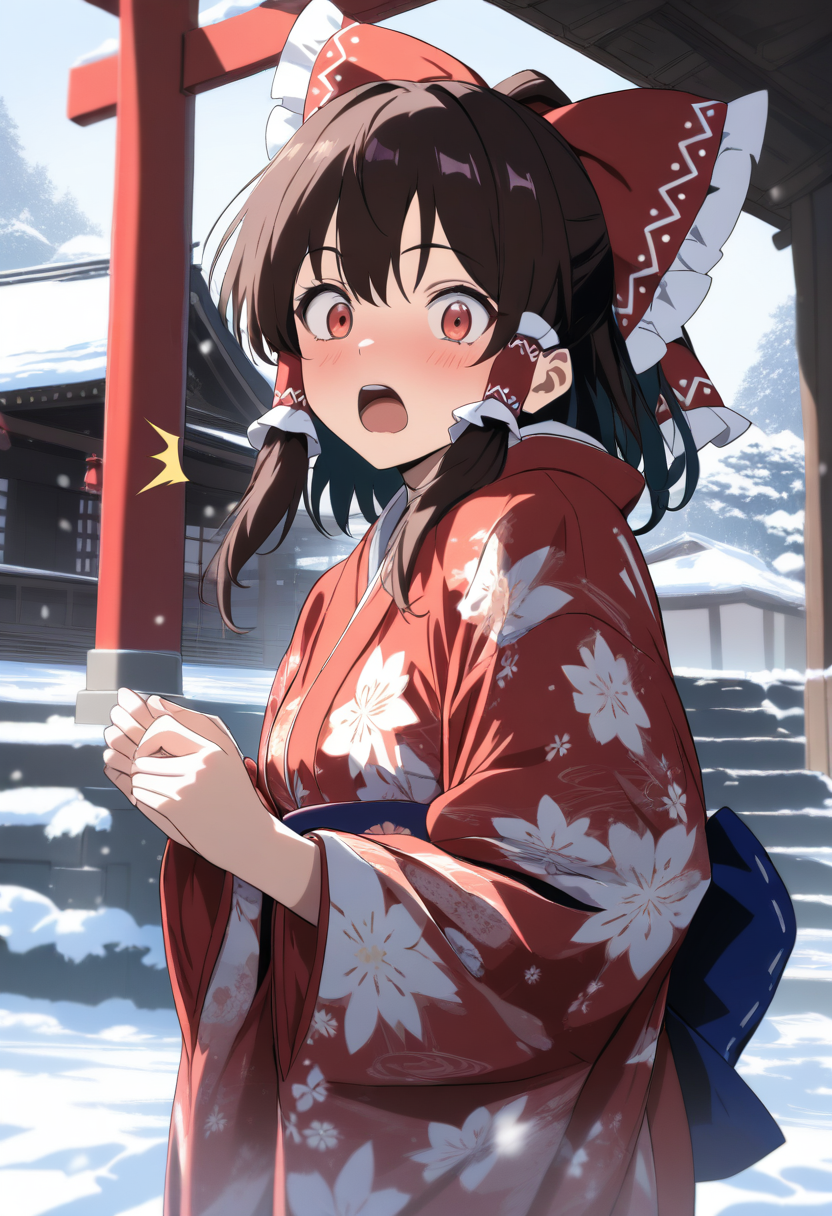

In [14]:
#@title (3) Creating illustrations for your novels/小説用挿絵の作成
result = run_in_colab(
    novel_text=novel_content,
    series_name=series_name.split('|')[0],
    character_name=character_name.split('|')[0],
    category=category.split('|')[0],
    style_name=image_style
)

#time.sleep(10)
#force_gpu_memory_release()

カスタムプロンプトを使用します:
1girl, hakurei reimu, touhou, looking at viewer, surprised, snow, outdoors, shrine, anime, digital art, red bow, miko, crab, general
画像生成モデルをロードしています...
プロンプト '1girl, hakurei reimu, touhou, looking at viewer, surprised, snow, outdoors, shrine, anime, digital art, red bow, miko, crab, general' で画像を生成しています...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

画像が生成されました: ./outputs/image_20250322_153812.png


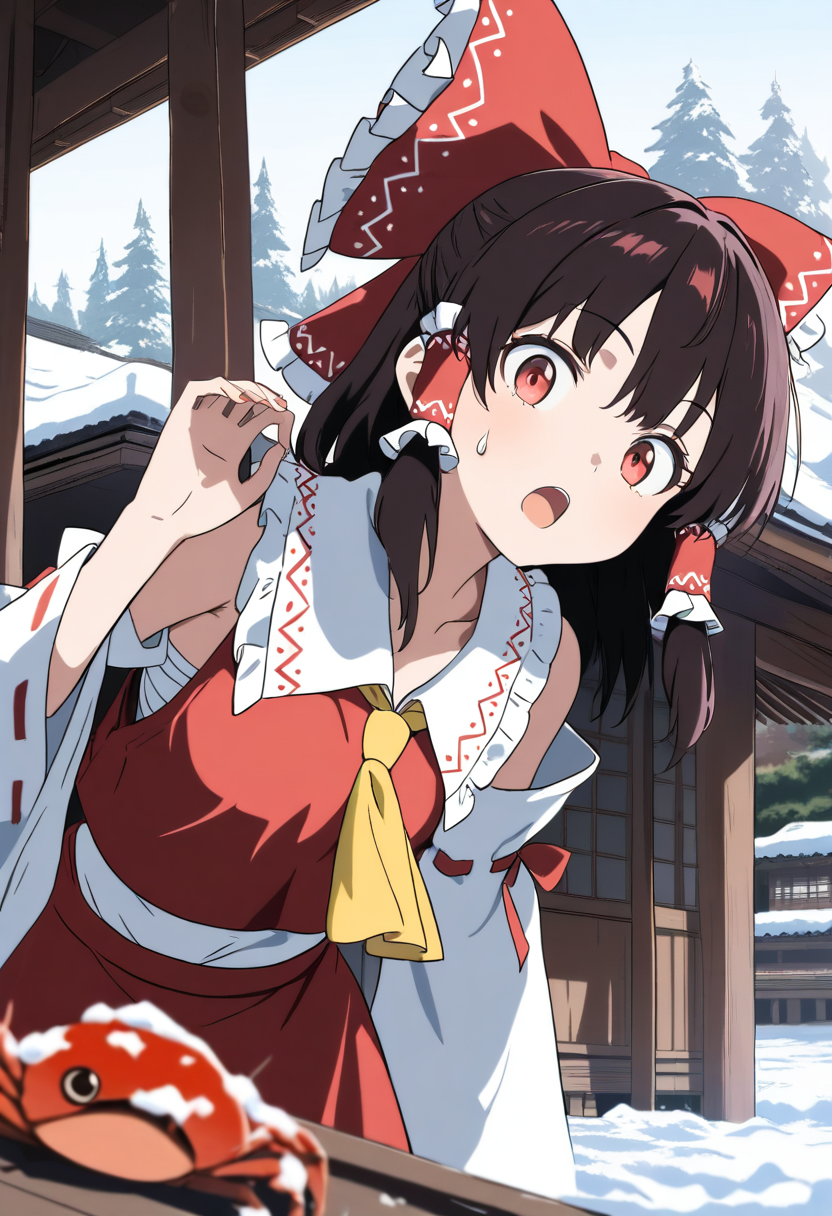

In [13]:
#@title (4)GPU Memory Management and Image Regeneration Controls/GPUメモリの強制解放と画像の再生成
from IPython.display import HTML, display


# 最後のプロンプトを取得してUIの初期表示に使用
last_prompt = load_last_prompt()

# UIボタン表示
html_content = f"""
<div style="padding: 10px; margin: 10px 0; background-color: #f8f9fa; border-radius: 5px;">
  <h3 style="margin-top: 0;">GPU Memory & Image regeneration control/GPUメモリ & 画像再生成コントロール</h3>

  <div style="margin-bottom: 15px;">
    <h4 style="margin-top: 10px;">prompt edit & regenarate image/プロンプト編集 & 画像再生成</h4>
    <textarea id="customPrompt" style="width: 100%; height: 100px; margin-bottom: 10px; padding: 8px; font-family: monospace; font-size: 14px;">{last_prompt}</textarea>
    <button onclick="regenerateWithCustomPrompt()" style="background-color: #007bff; color: white; padding: 8px 12px; border: none; border-radius: 4px; cursor: pointer;">
      Regenerated image using edited prompt/編集したプロンプトで画像生成
    </button>
    <button onclick="loadLastPrompt()" style="background-color: #6c757d; color: white; padding: 8px 12px; border: none; border-radius: 4px; margin-left: 10px; cursor: pointer;">
      load last prompt/最後のプロンプトを読み込む
    </button>
    <p style="font-size: 12px; color: #6c757d;">※you can edit prompt directly and make image again./プロンプトを編集して画像を再生成できます</p>
  </div>

  <div style="margin-bottom: 15px;">
    <button onclick="releaseGPUMemory()" style="background-color: #dc3545; color: white; padding: 8px 12px; border: none; border-radius: 4px; cursor: pointer;">
      Force GPU memory release with risk/GPUメモリ強制解放 (⚠️リスクあり)
    </button>
    <p style="font-size: 12px; color: #6c757d;">※If you recreate the image multiple times, the GPU memory may become full. This button is used in such cases. But maybe runtime become unstable.<br>
何度も再作成しているとGPUメモリが一杯になってしまう時があります。その時に使うボタンです。しかし実行すると動作が不安定になる可能性があります</p>
  </div>

</div>
<script>
function releaseGPUMemory() {{
  const button = document.querySelector("button");
  button.disabled = true;
  button.textContent = "releasing/解放処理中...";

  google.colab.kernel.invokeFunction('notebook.forceGPUMemoryRelease', [], {{}})
    .then(function() {{
      button.disabled = false;
      button.textContent = "Force GPU memory release with risk./GPUメモリ強制解放 (⚠️リスクあり)";
    }})
    .catch(function(error) {{
      console.error('Error:', error);
      button.disabled = false;
      button.textContent = "/Force GPU memory release error./GPUメモリ強制解放 (⚠️エラー発生)";
    }});
}}

function regenerateWithCustomPrompt() {{
  const textarea = document.getElementById('customPrompt');
  const prompt = textarea.value;
  const button = document.querySelectorAll("button")[1];

  button.disabled = true;
  button.textContent = "generate image/画像生成中...";

  google.colab.kernel.invokeFunction('notebook.generateWithCustomPrompt', [prompt], {{}})
    .then(function() {{
      button.disabled = false;
      button.textContent = "Regenerated image using edited prompt/編集したプロンプトで画像生成";
    }})
    .catch(function(error) {{
      console.error('Error:', error);
      button.disabled = false;
      button.textContent = "Regenerated image using edited prompt error/編集したプロンプトで画像生成 (⚠️エラー発生)";
    }});
}}

function loadLastPrompt() {{
  google.colab.kernel.invokeFunction('notebook.loadLastPrompt', [], {{}})
    .then(function(response) {{
      const prompt = response.data['application/json'].result;
      document.getElementById('customPrompt').value = prompt;
    }})
    .catch(function(error) {{
      console.error('Error:', error);
    }});
}}
</script>
"""

# コールバック関数の登録
from google.colab import output

output.register_callback('notebook.forceGPUMemoryRelease', force_gpu_memory_release)
output.register_callback('notebook.generateWithCustomPrompt', generate_with_custom_prompt)
output.register_callback('notebook.loadLastPrompt', load_last_prompt)

# UI表示
display(HTML(html_content))


## Acknowledgements/謝辞
We would like to thank the following people for providing related models/methods/tools.  
以下の関連モデル/手法/ツールを提供してくださった皆さんに感謝します。  
- Image Generation Model and style prompt [cagliostrolab/animagine-xl-4.0](https://huggingface.co/cagliostrolab/animagine-xl-4.0)
- Sample novel text [Coolier - 新生・東方創想話/博麗ベニズワイガニ](https://coolier.net/sosowa/ssw_l/193/1390706258)
- Base Model: [Qwen/Qwen2.5-3B-Instruct](https://huggingface.co/Qwen/Qwen2.5-3B-Instruct)
- Training Methods: (DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models)[https://arxiv.org/abs/2402.03300]
- Traing script: [Unsloth](https://huggingface.co/unsloth).
- [Danbooru tags](https://danbooru.donmai.us/wiki_pages/tag_groups) for tagging.
- [Huggingface]() for storage.

## Developer/開発

- **Developed by:** dahara1@webbigdata
- **Model type:** text generation
- **Language(s) (NLP):** Japanese, English
- **model :** [webbigdata/FanFic-Illustrator](https://huggingface.co/webbigdata/FanFic-Illustrator)